# **Predicting Fire Radiative Power Using a Neural Network**

## **Introduction**

This notebook explores the prediction Fire Radiative Power (FRP) using satellite data of Australian bushfires with a neural network. We’ll use the cleaned dataset from Question 1 and apply a PyTorch-based neural network to predict FRP. This notebook will include data preprocessing, training a neural network model, and evaluating its performance.

## **Importing Required Libraries**

The following libraries are used for data processing, neural network training, and visualisation:

- **`os`**: Handles file paths and directories.
- **`torch`**: PyTorch library for building and training neural networks.
- **`torch.nn`**: Contains classes for defining and training neural networks.
- **`torch.optim`**: Provides optimisation algorithms like Adam for training neural networks.
- **`sklearn.model_selection.train_test_split`**: Splits the dataset into training and testing subsets.
- **`sklearn.preprocessing.StandardScaler`**: Standardises features by removing the mean and scaling to unit variance.
- **`sklearn.metrics`**: Provides performance metrics like MSE and R² score.
- **`pandas`**: For data manipulation and analysis.
- **`geopandas`**: Handles geographic data for plotting maps of Australia.
- **`numpy`**: Core library for numerical computing.
- **`matplotlib.pyplot`**: Creates static visualisations like plots and charts.
- **`matplotlib.colors`**: Manages colour normalisation for visualisations.
- **`seaborn`**: Built on `matplotlib`, provides high-level statistical graphics.

In [323]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

## **Data Loading**

Since in Question 1 we did some preprocessing on the bushfires dataset, here we can begin by loading and exploring the cleaned dataset from Question 1 where we did things like capping the FRP to exclude extreme outliers, filtering out low-confidence rows, and dropping unnecessary columns.


In [324]:
# Load the dataset (your own filename or path may be different)
dataset_path = "/Users/ciaranbritton/Library/Mobile Documents/com~apple~CloudDocs/Ciaran's Folder/University/Year 4/Advanced Computational Techniques/cleaned_bushfires.csv"
df_cleaned = pd.read_csv(dataset_path)

In [325]:
# Display information on the dataset
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98514 entries, 0 to 98513
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   latitude      98514 non-null  float64
 1   longitude     98514 non-null  float64
 2   bright_ti4    98514 non-null  float64
 3   scan          98514 non-null  float64
 4   track         98514 non-null  float64
 5   acq_time      98514 non-null  int64  
 6   bright_ti5    98514 non-null  float64
 7   frp           98514 non-null  float64
 8   type          98514 non-null  int64  
 9   confidence_h  98514 non-null  bool   
 10  confidence_n  98514 non-null  bool   
 11  frp_capped    98514 non-null  float64
dtypes: bool(2), float64(8), int64(2)
memory usage: 7.7 MB


In [326]:
# Display the first rows of each column
df_cleaned.head()

,latitude,longitude,bright_ti4,scan,track,acq_time,bright_ti5,frp,type,confidence_h,confidence_n,frp_capped
0,-37.48861,149.63156,341.1,0.41,0.60,304,293.7,4.4,0,False,True,4.4
1,-33.94823,151.21292,341.1,0.62,0.54,305,295.3,6.4,0,False,True,6.4
2,-34.45618,150.87723,328.5,0.33,0.55,305,298.1,2.1,2,False,True,2.1
3,-31.60223,150.15147,367.0,0.34,0.56,306,302.4,19.3,0,True,False,19.3
4,-29.26867,149.46602,367.0,0.35,0.57,306,307.0,13.6,0,True,False,13.6


## **Data Visualisation - Fire Locations and FRP Over a Map of Australia:**

To get a better idea of what these data points actually show, this part visualises fire locations across Australia and their FRP. The fire locations will be plotted on a map and colour-coded by FRP values using a log scale to show the intensity of the fires. This provides insights into the spatial distribution and intensity of the fires.

This notebook is using a map of australia provided by Natural Earth data. The shapefile can be downloaded through this link in Admin 0 - Countries: https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.

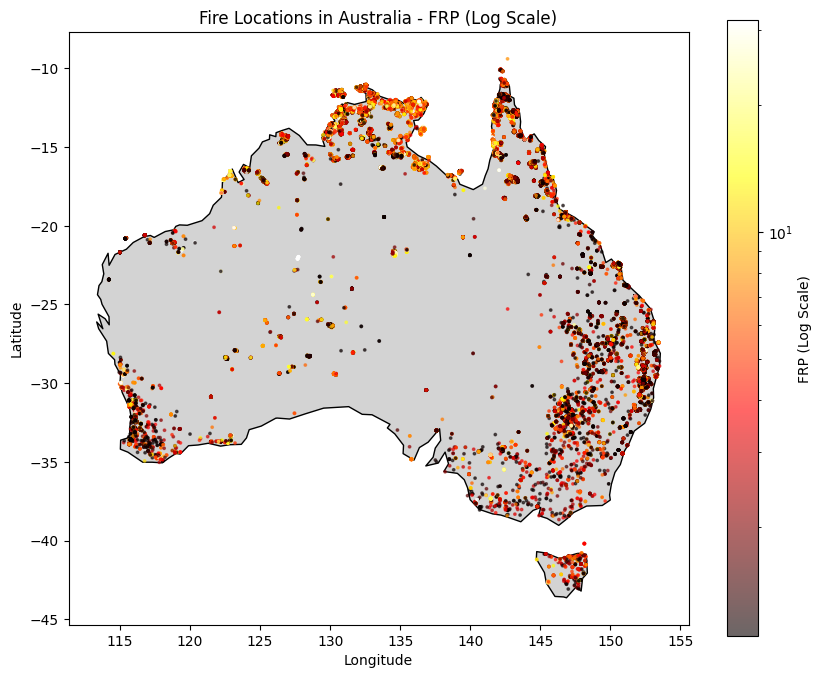

In [327]:
# Load the countries shapefile
shapefile_path = "/Users/ciaranbritton/Library/Mobile Documents/com~apple~CloudDocs/Ciaran's Folder/University/Year 4/Advanced Computational Techniques/ne_110m_admin_0_countries"
world = gpd.read_file(shapefile_path)

# Filter for Australia
australia = world[world["ADMIN"] == "Australia"]

# Plot fire locations with FRP colour mapping
norm = mcolors.LogNorm(vmin=df_cleaned["frp_capped"].min() + 1, vmax=df_cleaned["frp_capped"].max())

fig, ax = plt.subplots(figsize=(10, 8))
australia.plot(ax=ax, color="lightgrey", edgecolor="black")
sc = ax.scatter(
    df_cleaned["longitude"], df_cleaned["latitude"],
    c=df_cleaned["frp_capped"], cmap="hot", norm=norm, alpha=0.6, s=3
)
plt.colorbar(sc, ax=ax, label="FRP (Log Scale)")
plt.title("Fire Locations in Australia - FRP (Log Scale)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## **Feature Selection**
For our dataset, the most important features for predicting FRP are:

*   `bright_ti4`
*   `bright_ti5`
*   `latitude`
*   `longitude`
*   `scan`
*   `track`

Low confidence values have already been filtered out so any remaining rows are all nominal or high confidence, meaning confidence doesn't have to be used as a feature for training.

Our target variable is FRP, and we will be using the capped value so that any extreme outliers don't skew the model.

In [328]:
# Define X and y
X = df_cleaned[["bright_ti4", "bright_ti5", "scan", "track", "latitude", "longitude"]]  # Features
y = df_cleaned["frp_capped"]  # Target variable

## **Normalisation**

The dataset is normalised so that all the features the model will train on are standardised, meaning the model will perform better. This is done by using `StandardScalar` from the `sklearn` module, which scales all the features to have a mean of zero and a standard deviation of 1. By doing this, features cannot dominate over eachother which ensures a better training of the model.

An additional step required by some models is to encode the target variable, but this is only the case when the target variable is categorical. We're dealing with a continuous target varaible so encoding is not needed as it's already numerical

In [329]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## **Train and Test Data Split**

- **Training Set**: The training set is used to teach the model, i.e., to adjust the internal parameters of the model based on the input data and the target labels.
- **Test Set**: The test set is used to evaluate the performance of the trained model. It contains data that the model has never seen before, allowing us to assess how well it can make predictions on new, unseen data.

The 80-20 split is a common convention. In this split:
- **80%** of the data is used for training the model, ensuring the model has enough data to learn from.
- **20%** of the data is reserved for testing, which allows us to get an unbiased estimate of the model's performance.

`train_test_split` is used from **scikit-learn** to randomly divide the data into two sets. This function shuffles the data before splitting, ensuring the distribution of the data is randomised.

In [330]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## **Data Preparation for Training**

In order to have a functional and efficient neural network, there are some things we must first do to our dataset so that it can be input into a neural network.
 
 - **TensorDataset**: The `TensorDataset` class in PyTorch allows us to store our features (X) and labels (Y) as tensors in a dataset. This makes the data accessible in a format that PyTorch can process during model training and evaluation.
 
 - **DataLoader**: `DataLoader` is a PyTorch utility that provides easy access to batches of data. It takes care of batching, shuffling, and parallel loading. This is especially useful when dealing with large datasets that cannot fit entirely into memory.

 - **Batch Size**: The batch size is the number of samples processed before the model's internal parameters are updated. Here we specify a batch size of 64, which means the model will process 64 samples at once before updating weights. 


In [331]:
# Convert X_train and y_train to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  # Features
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)  # Target

# Convert X_test and y_test to tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)  # Features
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)  # Target

In [332]:
# Convert the training and testing data into PyTorch Tensors and then into TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)  # Create a dataset for training from features and labels
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)     # Create a dataset for testing from features and labels

# Set the batch size for training and testing
batch_size = 64

# Create DataLoader instances to handle batching and shuffling of data for more efficient training
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Shuffle the training data for each epoch
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # Do not shuffle test data (used for evaluation)

## **Creating a PyTorch Neural Network**

Here we define a simple feedforward neural network using PyTorch's `torch.nn` module. The model consists of an input layer, one hidden layer, and an output layer, organised in a sequential block.

- **Model Architecture**:
   - The input features are passed through a hidden layer with a specified number of neurons.
   - **ReLU** activation is applied to the hidden layer for non-linearity.
   - **Dropout** is added after the hidden layer with a rate of 20% to reduce overfitting by randomly setting half of the neurons to zero during training.
   - The output layer produces predictions for Fire Radiative Power (FRP).

- **Forward Pass**:
   - The forward pass defines how data flows from the input layer, through the hidden layer, and to the output layer for predictions.

- **Model Parameters**:
   - **input_dim**: The number of input features from the dataset (excluding the target).
   - **hidden_dim**: Number of neurons in the hidden layer (set to 64).
   - **output_dim**: Number of outputs (1, as we are predicting a continuous FRP value).

- **Loss Function and Optimiser**:
  - **Criterion (Loss Function)**: The model uses Mean Squared Error (MSE) loss, which is appropriate for regression tasks where the goal is to minimise the difference between predicted and actual values.
  - **Optimiser**: The `Adam` optimiser is used, which adapts the learning rate for each parameter.


In [333]:
# Define a simple feedforward neural network for predicting continuous values (regression)
class FRP_Regressor(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FRP_Regressor, self).__init__()
        # Define the layers of the network: input layer, hidden layer, and output layer
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),  # Transform input features to hidden layer
            nn.ReLU(),                         # Apply ReLU activation to the hidden layer
            nn.Dropout(p=0.2),  # Adding dropout with 50% probability
            nn.Linear(hidden_dim, 1)            # Output a single continuous value for regression
        )

    def forward(self, x):
        # Define how data passes through the network during forward propagation
        return self.fc(x)

# Set the input size and hidden layer size
input_dim = X_train.shape[1]  # The number of features in the dataset
hidden_dim = 64               # Number of neurons in the hidden layer

# Initialise the model with the chosen parameters
model = FRP_Regressor(input_dim, hidden_dim)

criterion = nn.MSELoss()  # Using Mean Squared Error for regression
optimiser = optim.Adam(model.parameters(), lr=0.01)

## Training the Model

The model is trained for 50 epochs, with each epoch involving a forward and backward pass. During the forward pass, the training data is fed through the neural network to generate predictions, which are then compared to the true values to calculate the loss. In the backward pass, gradients are calculated through backpropagation, and the model's parameters are updated accordingly using the Adam optimizer. The training process aims to minimize the loss function, and the average loss for each epoch is printed to track the model's progress throughout training.


In [334]:
train_losses = []  # Store the training loss at each epoch
test_losses = []   # Store the test (validation) loss at each epoch

# Training the neural network for 50 epochs
epochs = 50
for epoch in range(epochs):
    model.train()  # Set the model to training mode
    
    # Forward pass: Pass the training data through the model to get predictions
    predictions = model(X_train_tensor)
    
    # Calculate the loss by comparing the predictions to the true values
    loss = criterion(predictions, y_train_tensor)
    
    # Backward pass: Zero out previous gradients, calculate new gradients, and update the model parameters
    optimiser.zero_grad()  # Zero gradients for the next step
    loss.backward()        # Perform backpropagation to calculate gradients
    optimiser.step()       # Update the model parameters
    
    # Store the loss for this epoch
    train_losses.append(loss.item())

    # Evaluate on test data (validation data)
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient tracking for evaluation
        test_predictions = model(X_test_tensor)
        test_loss = criterion(test_predictions, y_test_tensor)
    
    # Store the test loss for this epoch
    test_losses.append(test_loss.item())

    # Print the average loss for every epoch
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [1/50], Loss: 126.8880
Epoch [2/50], Loss: 123.0059
Epoch [3/50], Loss: 119.2334
Epoch [4/50], Loss: 115.5951
Epoch [5/50], Loss: 112.0199
Epoch [6/50], Loss: 108.4917
Epoch [7/50], Loss: 104.9618
Epoch [8/50], Loss: 101.4433
Epoch [9/50], Loss: 97.9000
Epoch [10/50], Loss: 94.2828
Epoch [11/50], Loss: 90.6608
Epoch [12/50], Loss: 87.0244
Epoch [13/50], Loss: 83.1957
Epoch [14/50], Loss: 79.4325
Epoch [15/50], Loss: 75.7070
Epoch [16/50], Loss: 71.8755
Epoch [17/50], Loss: 68.2275
Epoch [18/50], Loss: 64.5845
Epoch [19/50], Loss: 61.0589
Epoch [20/50], Loss: 57.7664
Epoch [21/50], Loss: 54.6242
Epoch [22/50], Loss: 51.7444
Epoch [23/50], Loss: 49.2368
Epoch [24/50], Loss: 47.0010
Epoch [25/50], Loss: 45.0854
Epoch [26/50], Loss: 43.5957
Epoch [27/50], Loss: 42.3374
Epoch [28/50], Loss: 41.5396
Epoch [29/50], Loss: 40.9084
Epoch [30/50], Loss: 40.3968
Epoch [31/50], Loss: 40.2365
Epoch [32/50], Loss: 40.0970
Epoch [33/50], Loss: 39.8044
Epoch [34/50], Loss: 39.5712
Epoch [35/50], 

In [335]:
torch.save(model.state_dict(), "frp_regressor.pth")
print("frp_regressor.pth saved")

frp_regressor.pth saved


The model has now been saved, so that if needed it can be reloaded

## **Evaluating the Model**

After training the model, the following metrics are used to evaluate performance:

- **Mean Squared Error (MSE)**: The primary loss function used during training, MSE measures the average squared difference between predicted and actual values. A lower MSE indicates better model performance.

- **Root Mean Squared Error (RMSE)**: The square root of MSE, RMSE provides an error metric in the same unit as the target variable. Lower RMSE indicates better predictions.

- **R² Score**: A statistical measure that explains how well the model's predictions match the true values. R² ranges from 0 to 1, where values closer to 1 indicate better model performance.

In [336]:
# Evaluate the model on the training and test data
train_loss = criterion(model(X_train_tensor), y_train_tensor)
test_loss = criterion(model(X_test_tensor), y_test_tensor)

# Print the loss on both the training and test data
print(f"Training Loss (MSE): {train_loss.item():.4f}")
print(f"Test Loss (MSE): {test_loss.item():.4f}")

# Make predictions on the test data
y_pred = model(X_test_tensor).detach().numpy()

# Calculate RMSE and R² score
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

Training Loss (MSE): 32.9282
Test Loss (MSE): 33.1863
RMSE: 5.76
R²: 0.51


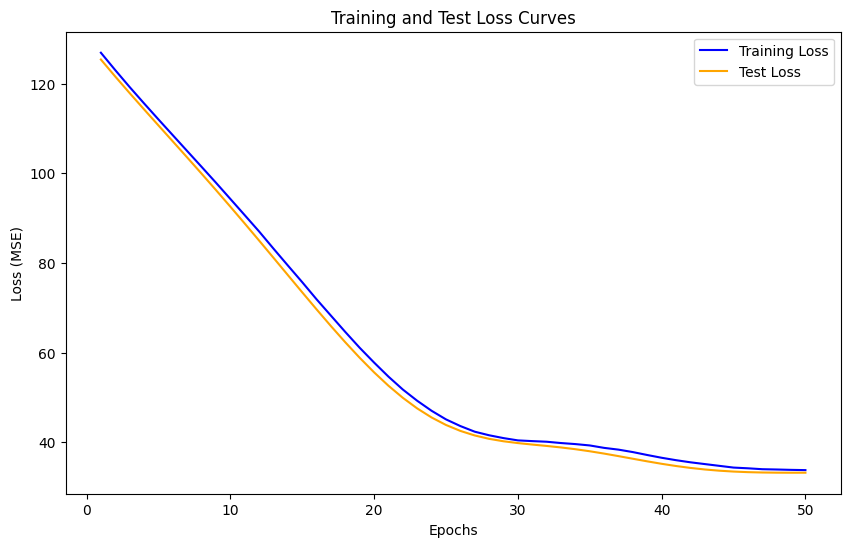

In [337]:
# Plotting the training and test loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Test Loss Curves')
plt.legend()
plt.show()

The **training loss** curve shows how well the model is fitting to the training data, with the loss typically decreasing as the model learns. The **test loss** curve indicates how well the model generalises to unseen data. Both curves decrease over time which is what it should look like, but if the test loss started increasing while the training loss decreased, it would indicate **overfitting**, meaning the model would become too specialised to the training data and not generalise well.

## **Feature Importance**

The importance of each feature used in the neural network model is assessed. The weights from the first layer are extracted, and the mean absolute weight for each feature is calculated. This gives an indication of how much each feature contributes to the prediction of FRP. The features are then sorted by importance, and a horizontal bar plot is generated to visually represent the feature importances.


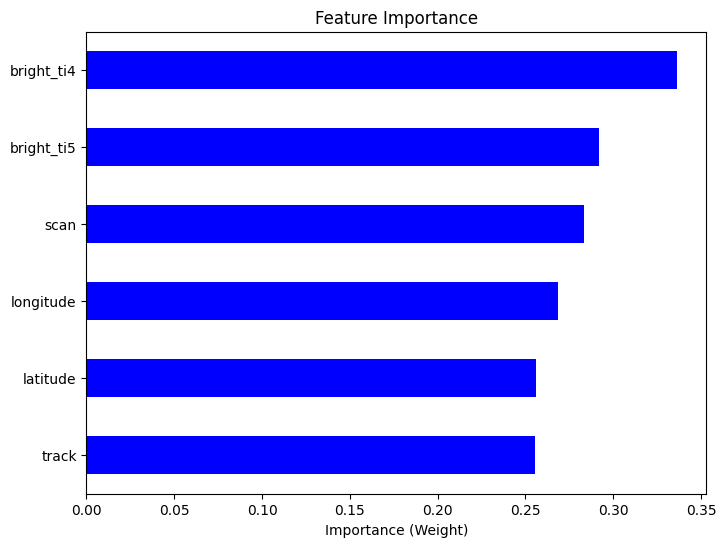

In [338]:
# Extract weights of the first layer
weights = model.fc[0].weight.detach().numpy()  # Get the weights from the first layer (input to hidden)
mean_absolute_weights = np.mean(np.abs(weights), axis=0)  # Take the mean absolute value for each feature

# Create a Pandas Series with feature names
feature_importance = pd.Series(mean_absolute_weights, index=X.columns).sort_values(ascending=False)

# Plotting the feature importance
plt.figure(figsize=(8, 6))
feature_importance.plot(kind='barh', color='blue')
plt.title("Feature Importance")
plt.xlabel("Importance (Weight)")
plt.gca().invert_yaxis()
plt.show()

## **Visualising Model Performance**

This section explores the model's performance and the relationships between the features and the target variable (FRP).

### 1. Actual vs Predicted FRP (Scatter Plot)
The scatter plot compares the actual FRP values to the predicted values. Each point represents a test data point, with the x-axis showing actual values and the y-axis showing predicted values. The red dashed line represents a perfect prediction. The closer the points are to this line, the better the model's performance. Discrepancies between the actual and predicted values, especially for higher FRP values, show where the model struggles to accurately predict extreme fire intensities.

### 2. Histogram of Prediction Errors
The histogram of prediction errors shows the distribution of differences between the predicted and actual FRP values. Ideally, the errors should be symmetrically distributed around zero, indicating that the model is unbiased. If the errors are skewed, this may suggest that the model consistently underpredicts or overpredicts certain values.

### 3. Distribution of Actual vs Predicted FRP
This plot compares the distributions of actual and predicted FRP values. The blue bars represent the actual values, and the orange bars represent the predicted values, alongside their respective Kernel Density Estimates (KDEs). The plot reveals how well the predicted values follow the actual distribution, highlighting any discrepancies in both the low- and high-intensity fire areas. This visualisation is crucial for understanding where the model performs well and where it struggles with extreme fire intensities.

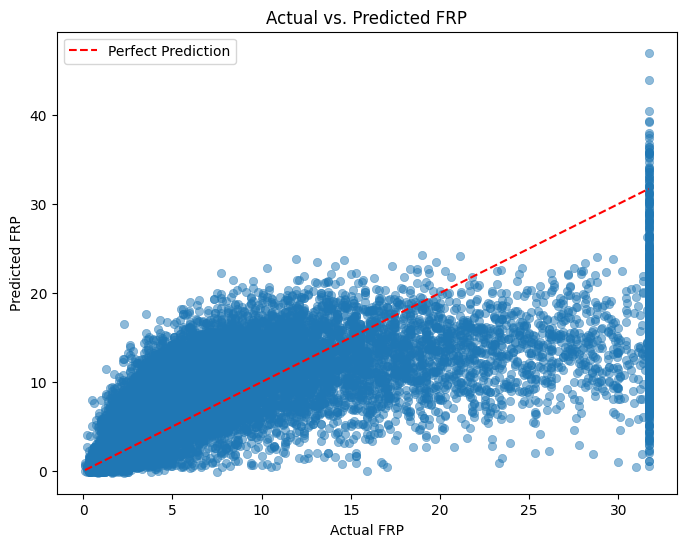

In [ ]:
# Convert y_test and y_pred to 1D arrays so that the scatter plot can be created
y_test = y_test.values.flatten()
y_pred = y_pred.flatten()

# Scatter plot: Actual vs. Predicted FRP
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, edgecolor=None)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Prediction")
plt.xlabel("Actual FRP")
plt.ylabel("Predicted FRP")
plt.title("Actual vs. Predicted FRP")
plt.legend()
plt.show()

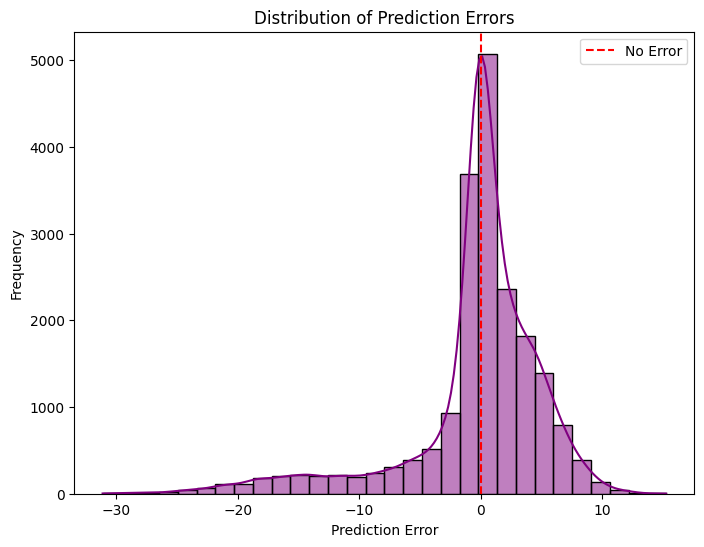

In [346]:
# Histogram of Prediction Errors
prediction_errors = y_pred - y_test
plt.figure(figsize=(8, 6))
sns.histplot(prediction_errors, bins=30, kde=True, color="purple")
plt.axvline(x=0, linestyle="--", color="red", label="No Error")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.legend()
plt.show()

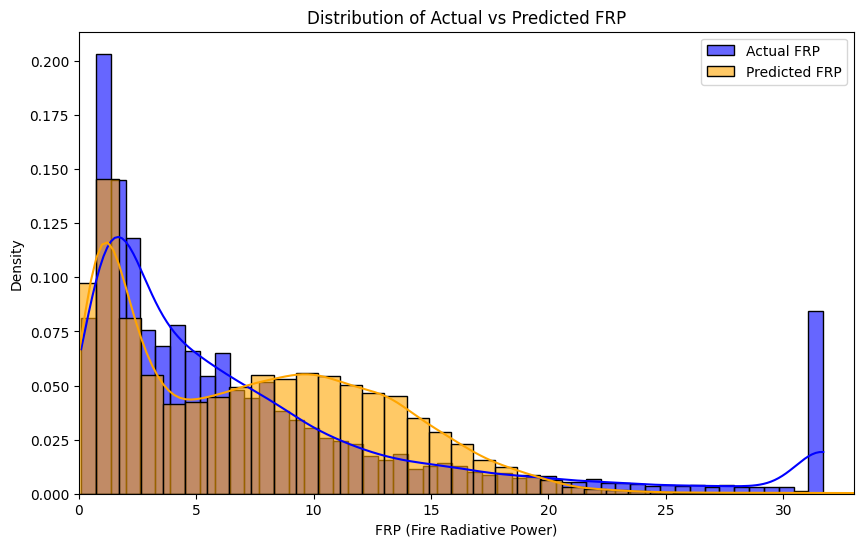

In [351]:
# Actual vs predicted FRP as histograms
plt.figure(figsize=(10, 6))
sns.histplot(y_test, bins=50, color="blue", kde=True, stat="density", label="Actual FRP", alpha=0.6)
sns.histplot(y_pred, bins=50, color="orange", kde=True, stat="density", label="Predicted FRP", alpha=0.6)
plt.xlim(0, 33)

plt.legend()
plt.title("Distribution of Actual vs Predicted FRP")
plt.xlabel("FRP (Fire Radiative Power)")
plt.ylabel("Density")
plt.show()

## **Comparing the Neural Network to Random Forest Regressor**

Both models will be evaluated based on the three key metrics we've been using: **Mean Squared Error (MSE)**, **Root Mean Squared Error (RMSE)**, and **R² Score**. These metrics will help us understand how well each model predicts the Fire Radiative Power (FRP), with lower MSE and RMSE values indicating better performance, and higher R² values indicating a better fit to the data.


In [353]:
# Neural Network Metrics
mse_nn = mean_squared_error(y_test, y_pred)
rmse_nn = np.sqrt(mse_nn)
r2_nn = r2_score(y_test, y_pred)

# Random Forest Metrics
mse_rf = 25.13  # From Q1
rmse_rf = 5.01   # From Q1
r2_rf = 0.63     # From Q1

print(f"Random Forest MSE: {mse_rf:.2f} | Neural Network MSE: {mse_nn:.2f}")
print(f"Random Forest RMSE: {rmse_rf:.2f} | Neural Network RMSE: {rmse_nn:.2f}")
print(f"Random Forest R²: {r2_rf:.2f} | Neural Network R²: {r2_nn:.2f}")

Random Forest MSE: 25.13 | Neural Network MSE: 33.19
Random Forest RMSE: 5.01 | Neural Network RMSE: 5.76
Random Forest R²: 0.63 | Neural Network R²: 0.51


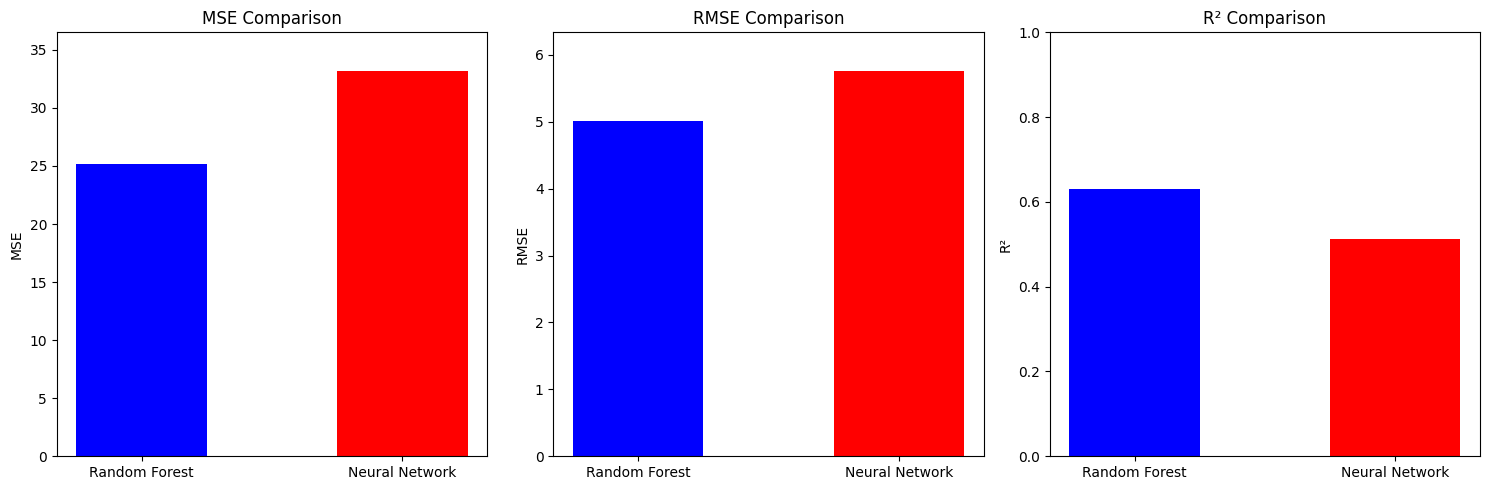

In [ ]:
metrics = ['MSE', 'RMSE', 'R²']

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Create the bar plots for each metric
axs[0].bar(['Random Forest', 'Neural Network'], [mse_rf, mse_nn], color=['blue', 'red'], width=0.5)
axs[0].set_title('MSE Comparison')
axs[0].set_ylabel('MSE')
axs[0].set_ylim(0, max(mse_rf, mse_nn) * 1.1)

axs[1].bar(['Random Forest', 'Neural Network'], [rmse_rf, rmse_nn], color=['blue', 'red'], width=0.5)
axs[1].set_title('RMSE Comparison')
axs[1].set_ylabel('RMSE')
axs[1].set_ylim(0, max(rmse_rf, rmse_nn) * 1.1)

axs[2].bar(['Random Forest', 'Neural Network'], [r2_rf, r2_nn], color=['blue', 'red'], width=0.5)
axs[2].set_title('R² Comparison')
axs[2].set_ylabel('R²')
axs[2].set_ylim(0, 1) 

plt.tight_layout()
plt.show()

## **Analysis of Model Performances**

- **MSE**: The Random Forest model has an MSE of 25.13, which is lower than the Neural Network's MSE of 33.19. This means that the Random Forest model has smaller prediction errors on average compared to the Neural Network.

- **RMSE**: Similarly, the RMSE shows a lower value for Random Forest of 5.01, compared to the Neural Network's RMSE of 5.76, confirming that the Random Forest model makes more accurate predictions in terms of overall error.

- **R²**: The R² score for Random Forest is 0.63, meaning that it explains 63% of the variance in FRP. The Neural Network's R² score is 0.51, which is lower, showing that while the Neural Network can explain less of the variance than the Random Forest.

The Neural Network model in this case performs worse than the Random Forest model in terms of MSE, RMSE, and R². This could be due to several factors, such as the relationship between the input features and the target variable (FRP) being more lienar which makes the Random Forest, a simpler model, more suitable for this type of problem.

Additionally, the Neural Network may be struggling with overfitting, especially since the model not been optimally tuned. Given the dataset and problem complexity, the Random Forest model provides more accurate and stable predictions compared to the Neural Network.